<a href="https://colab.research.google.com/github/riddhi365/CO2-Prediction-ML-vs-Regression/blob/main/DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
 data = pd.read_csv('CO2 emission by Vehicles.csv')
 original_mean_co2 = data["CO2 Emissions(g/km)"].mean()
 original_stddev_co2 = data["CO2 Emissions(g/km)"].std()
 #selectig the numeric data for normalization
 numeric_data=data.select_dtypes(include=['number'])
 #normalizing
 mean=numeric_data.mean()
 stddev = numeric_data.std()
 normalized_data=(numeric_data-mean)/stddev
 #merging the non numeric stuff back to the numeric stuff(for classification)
 for col in data.columns:
  if col not in normalized_data.columns:
    normalized_data[col]=data[col]
 normalized_data.head()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Make,Model,Vehicle Class,Transmission,Fuel Type
0,-0.856663,-0.883348,-0.758950,-1.052709,-0.855684,0.763059,-0.932870,ACURA,ILX,COMPACT,AS5,Z
1,-0.561279,-0.883348,-0.387551,-0.603161,-0.475391,0.209952,-0.505612,ACURA,ILX,COMPACT,M6,Z
2,-1.225893,-0.883348,-1.873149,-1.457303,-1.754558,2.837208,-1.958288,ACURA,ILX HYBRID,COMPACT,AV7,Z
3,0.251026,0.210561,0.040987,0.026206,0.043191,-0.343155,0.075459,ACURA,MDX 4WD,SUV - SMALL,AS6,Z
4,0.251026,0.210561,-0.130428,-0.153613,-0.129670,-0.066601,-0.112535,ACURA,RDX AWD,SUV - SMALL,AS6,Z


In [ ]:
 encoded_data = pd.get_dummies(normalized_data, drop_first=True)
 data_array = np.asarray(encoded_data)
 # Splitting features and target
 Y = data_array[:, 0:1]  # Assuming the target is CO2 Emissions
 X = data_array[:, 1:]   # Rest of the columns as features
 Y = encoded_data["CO2 Emissions(g/km)"].values.reshape(-1,1)
 X = encoded_data.drop(columns=["CO2 Emissions(g/km)"]).values
 # Adding bias term
 one = np.ones((len(X), 1))
 X = np.concatenate((one, X), axis=1)
 mean = np.mean(Y)
 stddev = np.std(Y)
 # Splitting into training and testing sets (90-10 split)
 split_ratio = 0.9
 split = int(split_ratio * X.shape[0])
 X_train = X[:split, :]
 X_test = X[split:, :]
 Y_train = Y[:split, :]
 Y_test = Y[split:, :]
 # Checking the shapes of the splits
 print("Training features shape:", X_train.shape)
 print("Testing features shape:", X_test.shape)
 print("Training target shape:", Y_train.shape)
 print("Testing target shape:", Y_test.shape)

Training features shape: (6646, 2145)
Testing features shape: (739, 2145)
Training target shape: (6646, 1)
Testing target shape: (739, 1)


In [ ]:
 def computeCost(X, y, theta, lam):
    """ Compute cost with L2 regularization """
    error = np.power((X.dot(theta.T) - y), 2)
    reg_term = lam * np.sum(np.power(theta, 2))  # L2 Regularization
    return np.sum(error + reg_term) / (2 * len(X))


In [ ]:
 def denormalise_emission(emission):
    return (emission * original_stddev_co2) + original_mean_co2
 def computeError(predicted, actual):
    """ Calculate Mean Absolute Percentage Error (MAPE) """
    error = np.abs(actual - predicted) / actual
    return np.mean(error) * 100  # Convert to percentage
 def plotGraph(x, y, labelX='Feature', labelY='CO2 Emissions (g/km)', title='Feature vs CO2 Emissions'):
    """ Plot data with appropriate labels """
    fig, ax = plt.subplots()
    ax.plot(x, y, 'r')
    ax.set_xlabel(labelX)
    ax.set_ylabel(labelY)
    ax.set_title(title)
    plt.show()

In [ ]:
def gradientDescent(X, y, theta, iters, alpha, lam):
    X = X.astype(float)  # Ensure X is float
    y = y.astype(float)  # Ensure y is float
    theta = theta.astype(float)  # Ensure theta is float
    lam_matrix = lam * np.ones(theta.shape)
    lam_matrix[0][0] = 0  # No regularization for bias term
    for i in range(iters):
        gradient = (X.T @ (X @ theta.T - y)) / len(X)  # Compute gradient
        theta = theta * (1 - lam_matrix / len(X)) - alpha * gradient.T  # Update theta
    return theta
def miniBatchGradientDescent(X, y, theta, iters, alpha, lam, batch_size=32):
    m = len(y)
    for i in range(iters):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for j in range(0, m, batch_size):
            X_batch = X_shuffled[j:j+batch_size]
            y_batch = y_shuffled[j:j+batch_size]

            gradient = (X_batch.T @ (X_batch @ theta.T - y_batch)) / len(X_batch)
            theta = theta * (1 - lam / len(X_batch)) - alpha * gradient.T
    return theta

# Momentum-Based Gradient Descent
def momentumGradientDescent(X, y, theta, iters, alpha, lam, beta=0.9):
    m = len(y)
    velocity = np.zeros(theta.shape)
    for i in range(iters):
        gradient = (X.T @ (X @ theta.T - y)) / m
        velocity = beta * velocity + (1 - beta) * gradient.T
        theta = theta * (1 - lam / m) - alpha * velocity
    return theta

# Adam Optimizer
def adamOptimizer(X, y, theta, iters, alpha, lam, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = len(y)
    m_t = np.zeros(theta.shape)
    v_t = np.zeros(theta.shape)

    for i in range(1, iters + 1):
        gradient = (X.T @ (X @ theta.T - y)) / m
        m_t = beta1 * m_t + (1 - beta1) * gradient.T
        v_t = beta2 * v_t + (1 - beta2) * (gradient.T ** 2)

        m_t_hat = m_t / (1 - beta1 ** i)
        v_t_hat = v_t / (1 - beta2 ** i)

        theta = theta * (1 - lam / m) - alpha * (m_t_hat / (np.sqrt(v_t_hat + epsilon)))

    return theta

In [ ]:
 # Normal Equation with L2 Regularization (Ridge Regression)
 def normalEquation(X, Y, lam):
    n = X.shape[1]  # Number of features
    lam_matrix = lam * np.identity(n)  # Regularization matrix
    lam_matrix[0, 0] = 0  # No regularization on bias term (theta[0])
    # Compute theta using the normal equation
    theta = np.linalg.pinv(X.T @ X + lam_matrix) @ X.T @ Y
    return theta

Optimal Lambda: 1
Final Error: 2.1478465222070793 %
Final Accuracy: 97.85215347779292 %


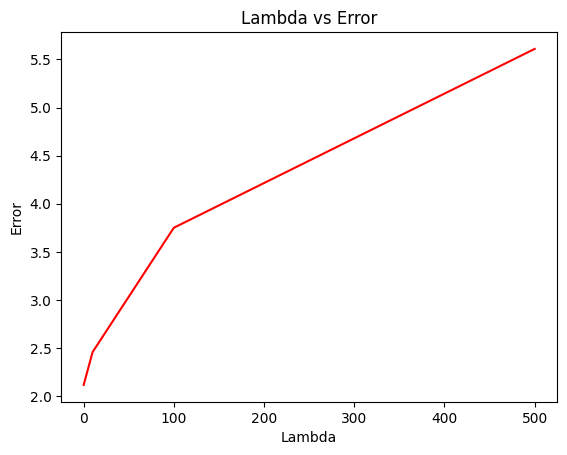

In [ ]:
 from sklearn.model_selection import GridSearchCV
 from sklearn.linear_model import Ridge  # Ridge Regression (L2 Regularization)
 # Step 1: Find the best lambda using GridSearchCV
 lambda_values = [0.1, 1, 10, 100, 500]  # Test these values
 ridge = Ridge()
 grid = GridSearchCV(ridge, param_grid={'alpha': lambda_values}, cv=5)  # 5-fold cross-validation
 grid.fit(X_train, Y_train)
 # Get the best lambda
 best_lambda = grid.best_params_['alpha']
 print("Optimal Lambda:", best_lambda)
 # Step 2: Use this lambda in gradient descent
 theta = np.zeros([1, X.shape[1]])  # Initialize theta
 alpha = 0.1  # Learning rate
 iters = 500  # Reduced iterations
 # Train using the best lambda
 theta_opt = gradientDescent(X_train, Y_train, theta, iters, alpha, best_lambda)
 # Compute error on test data
 Y_pred = X_test @ theta_opt.T  # Vectorized prediction
 error = computeError(denormalise_emission(Y_pred), denormalise_emission(Y_test))
 print("Final Error:", error, "%")
 accuracy = 100 - error  # Assuming error is in percentage

# Print final accuracy below the final error

 print("Final Accuracy:", accuracy, "%")
 error_matrix = []  # Initialize an empty list to store errors
 for lam in lambda_values:
    theta_temp = gradientDescent(X_train, Y_train, theta, iters, alpha, lam)
    Y_pred_temp = X_test @ theta_temp.T  # Prediction for this lambda
    error_temp = computeError(denormalise_emission(Y_pred_temp), denormalise_emission(Y_test))
    error_matrix.append(error_temp)  # Append error
 # Convert to numpy array for plotting (optional)
 error_matrix = np.array(error_matrix)
 # Plot error vs lambda
 plotGraph(lambda_values, error_matrix, 'Lambda', 'Error', 'Lambda vs Error')

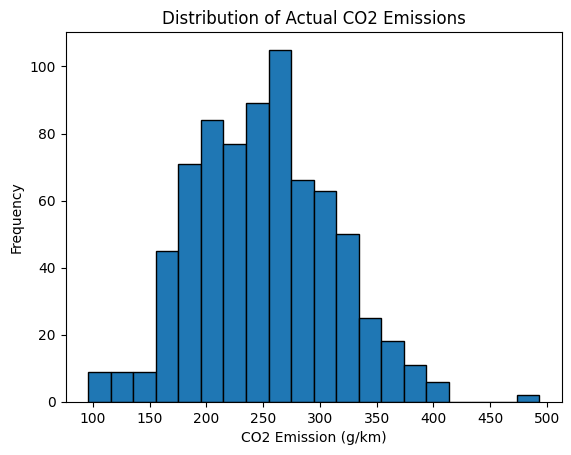

In [ ]:
import matplotlib.pyplot as plt

actual_co2_values = [denormalise_emission(y[0]) for y in Y_test]
plt.hist(actual_co2_values, bins=20, edgecolor='black')
plt.xlabel("CO2 Emission (g/km)")
plt.ylabel("Frequency")
plt.title("Distribution of Actual CO2 Emissions")
plt.show()

In [ ]:
 print(min(Y_pred), max(Y_pred))
 min_predicted = denormalise_emission(-2.9887)
 max_predicted = denormalise_emission(3.6237)
 print("Min Predicted CO2:", min_predicted)
 print("Max Predicted CO2:", max_predicted)

[-2.988768704695965] [3.6237325081135334]
Min Predicted CO2: 75.70785380754603
Max Predicted CO2: 462.6170950351194


In [ ]:
 print("Original Mean CO2:", original_mean_co2)
 print("Original Stddev CO2:", original_stddev_co2)
 # Define the classify_emission function
 def classify_emission(co2_value):
    if co2_value <= 120:
        return 'Eco-Friendly'
    elif 121 <= co2_value <= 170:
        return 'Moderate Emissions'
    elif 171 <= co2_value <= 250:
        return 'High Emissions'
    else:
        return 'Very High Emissions'
 try:
    # Load the CSV file (replace 'your_dataset.csv' with your actual file name)
    df = pd.read_csv('CO2 emission by Vehicles.csv')

    # Extract car models and vehicle classes
    car_models_test = df['Make'].tolist()  # Replace 'car_model' with your actual column name
    vehicle_classes_test = df['Vehicle Class'].tolist() # Replace 'vehicle_class' with your actual column name

    num_samples = len(Y_test) # get the amount of test samples

    for i in range(num_samples):
        predicted_co2 = denormalise_emission(Y_pred[i][0])
        actual_co2 = denormalise_emission(Y_test[i][0])

        predicted_class = classify_emission(predicted_co2)
        actual_class = classify_emission(actual_co2)
        print(f"Car: {car_models_test[i]:<15} | Class: {vehicle_classes_test[i]:<25} | "
              f"Predicted CO2 = {predicted_co2:.2f} ({predicted_class:<35}) | "
              f"Actual CO2 = {actual_co2:.2f} ({actual_class:<35})")

    print("Original Mean CO2:", original_mean_co2)
    print("Original Stddev CO2:", original_stddev_co2)

 except FileNotFoundError:
    print("Error: Dataset file not found. Please provide the correct file path.")
 except KeyError as e:
    print(f"Error: Column '{e.args[0]}' not found in the dataset. Please check column names.")


Original Mean CO2: 250.58469871360867
Original Stddev CO2: 58.512679394406476
Car: ACURA           | Class: COMPACT                   | Predicted CO2 = 198.11 (High Emissions                     ) | Actual CO2 = 199.00 (High Emissions                     )
Car: ACURA           | Class: COMPACT                   | Predicted CO2 = 244.42 (High Emissions                     ) | Actual CO2 = 250.00 (High Emissions                     )
Car: ACURA           | Class: COMPACT                   | Predicted CO2 = 232.49 (High Emissions                     ) | Actual CO2 = 234.00 (High Emissions                     )
Car: ACURA           | Class: SUV - SMALL               | Predicted CO2 = 208.58 (High Emissions                     ) | Actual CO2 = 211.00 (High Emissions                     )
Car: ACURA           | Class: SUV - SMALL               | Predicted CO2 = 223.97 (High Emissions                     ) | Actual CO2 = 227.00 (High Emissions                     )
Car: ACURA           | Clas

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the dataset
df = pd.read_csv("CO2 emission by Vehicles.csv")

# Step 2: Drop unnecessary columns ('Make' and 'Model')
df = df.drop(['Make', 'Model'], axis=1)

# Step 3: Separate the target and features
y = df['CO2 Emissions(g/km)']  # Target variable
X = df.drop('CO2 Emissions(g/km)', axis=1)  # Features

# Step 4: One-hot encode the categorical variables (like 'Fuel Type', etc.)
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 6: Train the standard Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Step 8: Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 9: Print the results
print(" Standard Linear Regression Results:")
print("🔹 Mean Squared Error (MSE):", mse)
print("🔹 R² Score:", r2)


 Standard Linear Regression Results:
🔹 Mean Squared Error (MSE): 32.788286869755055
🔹 R² Score: 0.9904674887950905


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess the data
df = pd.read_csv("CO2 emission by Vehicles.csv")
df = df.drop(['Make', 'Model'], axis=1)

y = df['CO2 Emissions(g/km)']
X = df.drop('CO2 Emissions(g/km)', axis=1)
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Models to compare
models = {
    "Ridge Regression": Ridge(alpha=1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf'),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Evaluate and store results
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'Model': name,
        'Mean Squared Error (MSE)': round(mse, 6),
        'R² Score': round(r2, 6)
    })

# Display comparison
comparison_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
print("\n Model Comparison:\n")
print(comparison_df.to_string(index=False))



 Model Comparison:

            Model  Mean Squared Error (MSE)  R² Score
    Random Forest                 16.777676  0.995122
    Decision Tree                 17.792416  0.994827
Gradient Boosting                 22.627694  0.993421
 Ridge Regression                 32.310163  0.990606
    KNN Regressor                 35.466080  0.989689
              SVR                409.021210  0.881086
